## Question 1

### Co-occurrence Matrix
Use the provided code the load the "Alice in Wonderland" text document. 
1. Implement the co-occurrence matrix for “Alice in Wonderland”
2. Normalize the matrix values (between 0 and 1)
3. Compute relationships between given words: 
    - A and B
    - A and C
    - B and C
4. List the 5 closest words to 'Alice'(?). Discuss the results
5. Discuss:
    - What are the main drawback of co-occurence matrix solutions


In [1]:
import numpy as np
np.random.seed(13) #TODO Check if this is used for sgd
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, Reshape, Lambda
from keras.utils import np_utils
from keras.utils.data_utils import get_file
from keras.preprocessing.text import Tokenizer
from keras.utils.vis_utils import model_to_dot
from keras.preprocessing import sequence
from gensim.models import KeyedVectors
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors as nn
from itertools import islice
from matplotlib import pylab
from __future__ import division

Using TensorFlow backend.


In [2]:
# DO NOT Modify the lines in this cell
path = 'alice.txt'
corpus = open(path).readlines()[0:700]

corpus = [sentence for sentence in corpus if sentence.count(" ") >= 2]

tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'+"'")
tokenizer.fit_on_texts(corpus)
corpus = tokenizer.texts_to_sequences(corpus)
nb_samples = sum(len(s) for s in corpus)
V = len(tokenizer.word_index) + 1

# Is this something they need to change?
dim = 100
window_size = 2
window_size_corpus = 4

In [30]:
def get_co_occurrence_matrix(V,corpus):
    V_matrix = np.zeros((V,V - 1))
    for words in corpus:
        L = len(words)
        for index, word in enumerate(words):
            p = index - window_size_corpus
            n = index + window_size_corpus + 1
            for i in range(p,n):
                if 0 <= i < L:
                    if words[i] != word:
                        real_word = words[i]
                        V_matrix[word][real_word - 1] = V_matrix[word][real_word - 1] + 1
    #you do not necessarily have to normalize, is done as well in the cosine similarity
    max = np.amax(V_matrix)
    V_matrix = np.divide(V_matrix,max)
    return V_matrix

matrix = get_co_occurrence_matrix(V,corpus)

#get word relations
index_alice = tokenizer.word_index["alice"]
index_she = tokenizer.word_index["she"]
index_rabbit = tokenizer.word_index["rabbit"]

similarity = cosine_similarity([matrix[index_alice],matrix[index_she],matrix[index_rabbit]])

#get nearest neighbors (this creates a list of all nearest neighbors of the matrix)
nbrs = nn(n_neighbors=2, algorithm='ball_tree').fit(matrix[1:,])

In [42]:
distances, indices = nbrs.kneighbors(matrix[1:,])
#nearest neighbor is always itself
nearest_alice = np.add(indices[index_alice - 1],1)

for key in tokenizer.word_index.keys():
    if tokenizer.word_index[key] in nearest_alice:
        print(key)

[[   0    4]
 [   1    8]
 [   2    4]
 ...
 [1179 1086]
 [1180  720]
 [1181  796]]
11
[10 13]
1
[11 14]
alice
her


In [32]:
f = open('vectors_co_occurrence.txt',"w")
f.write(" ".join([str(V-1),str(V-1)]))
f.write("\n")

1

In [33]:
vectors = get_co_occurrence_matrix(V,corpus)
for word, i in tokenizer.word_index.items():    
    f.write(word)
    f.write(" ")
    f.write(" ".join(map(str, list(vectors[i,:]))))
    f.write("\n")
f.close()

In [ ]:
from scipy import linalg
from sklearn.metrics.pairwise import cosine_similarity

def cos_sim(a, b):
    sim = cosine_similarity([a],[b])
    return sim[0][0]

def get_mean(positive_words,negative_words):
    sum = 0
    if len(positive_words+negative_words) > 0:
        for value in positive_words:
            sum = sum + value
        for value in negative_words:
            sum = sum - value
        return (sum/len(positive_words + negative_words))
    else:
        return None

def get_values_words(words,model):
    values = []
    for word in words:
        try:
            values.append(model[word])
        except KeyError:
            continue
    return values


In [ ]:
# TODO add empty shell call here to be implemented by the students


## Question 2

### Word embedding
Use the provided code the load the "Alice in Wonderland" text document. For the word embeddings, build embeddings with a keras implementation where the word embedding vector is of length 50, 100 and 300.
1. Create a word co-occurrence matrix for the Alice in Wonderland book. Normalize the rows between 0 and 1. 
2. Using the CBOW model
3. Using Skipgram model
4. Using Skipgram with negative sampling 
5. Add an extra Dense hidden layer. Decide on which activation function to use. 
6. Analyze the 4 different word embeddings as well as the word co-occurence matrix
    - Compare the performance on the analogy task
    - Synonyms examples
    - Visualize the word embeddings and interpret the results
7. Discuss:
    - What are the main advantages of CBOW and Skipgram
    - What is the advantage of negative sampling
8. Load pre-trained embeddings on large corpuses
    - Compare preformance with embeddings from "Alice in Wonderland"

(*) Negative sampling may be too hard: http://adventuresinmachinelearning.com/word2vec-keras-tutorial/


In [117]:
def generate_data_skipgram(corpus, window_size, V):
    maxlen = window_size*2
    all_in = []
    all_out = []
    for words in corpus:
        L = len(words)
        for index, word in enumerate(words):
            p = index - window_size
            n = index + window_size + 1
                    
            in_words = []
            labels = []
            for i in range(p, n):
                if i != index and 0 <= i < L:
                    in_words.append([word])
                    labels.append(words[i])
            if in_words != []:
                all_in.append(np.array(in_words,dtype=np.int32))
                all_out.append(np_utils.to_categorical(labels, V))
    return (all_in,all_out)



In [89]:
x,y = generate_skipgram(corpus,window_size,V)

[array([[242],
       [242]], dtype=int32)] [array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])]


In [118]:
f = open('data_skipgram.txt' ,'w')
#f.write(" ".join(["Input","Output"]))
#f.write("\n")

for input,outcome  in zip(x,y):
    input = np.concatenate(input)
    f.write(" ".join(map(str, list(input))))
    f.write(",")
    outcome = np.concatenate(outcome)
    f.write(" ".join(map(str,list(outcome))))
    f.write("\n")
f.close()

In [57]:
def generate_data_skipgram_from_file():
    f = open('data_skipgram.txt' ,'r')
    for row in f:
        inputs,outputs = row.split(",")
        inputs = np.fromstring(inputs, dtype=int, sep=' ')
        inputs = np.asarray(np.split(inputs, len(inputs)))
        outputs = np.fromstring(outputs, dtype=float, sep=' ')
        outputs = np.asarray(np.split(outputs, len(inputs)))
        yield (inputs,outputs)
    

In [54]:
skipgram = Sequential()
skipgram.add(Embedding(input_dim=V, output_dim=dim, embeddings_initializer='glorot_uniform', input_length=1))
skipgram.add(Reshape((dim, )))
skipgram.add(Dense(input_dim=dim, units=V, kernel_initializer='uniform', activation='softmax'))

In [55]:
skipgram.compile(loss='categorical_crossentropy', optimizer='adadelta')

In [58]:
for ite in range(10):
    loss = 0.
    for x, y in generate_data_skipgram_from_file():
        loss += skipgram.train_on_batch(x, y)

    print(ite, loss)

0 41238.4554476738
1 39012.115315914154
2 39125.7158806324
3 39168.993712067604
4 39212.45385169983
5 39276.85654056072
6 39359.990886330605
7 39451.47874188423
8 39541.969156742096
9 39626.41223037243


In [59]:
f = open('vectors_skipgram.txt' ,'w')
f.write(" ".join([str(V-1),str(dim)]))
f.write("\n")

1

In [60]:
vectors = skipgram.get_weights()[0]
for word, i in tokenizer.word_index.items():
    f.write(word)
    f.write(" ")
    f.write(" ".join(map(str, list(vectors[i,:]))))
    f.write("\n")
f.close()

[[ 0.02254011 -0.06140046 -0.02511747 ... -0.0478965  -0.01318541
   0.05537845]
 [-0.0465889   0.28235874  0.1893162  ... -0.07674798  0.00753748
  -0.21434283]
 [ 0.17370558 -0.08168204 -0.27692574 ...  0.07568481 -0.07198212
   0.06879576]
 ...
 [ 0.03207109  0.06181051  0.04763104 ...  0.02547662  0.02598553
  -0.03678954]
 [-0.0410199   0.05295342  0.04624333 ...  0.07697851 -0.05480968
   0.01571657]
 [ 0.03111805  0.04182531  0.04530334 ... -0.00335744 -0.07465491
   0.00265446]]


CBOW implementation starts here

In [18]:
def generate_data_cbow(corpus, window_size, V):
    maxlen = window_size*2
    all_in = []
    all_out = []
    for words in corpus:
        L = len(words)
        for index, word in enumerate(words):
            contexts = []
            labels   = []            
            s = index - window_size
            e = index + window_size + 1
            
            contexts.append([words[i] for i in range(s, e) if 0 <= i < L and i != index])
            labels.append(word)

            #all_in.append(sequence.pad_sequences(contexts, maxlen=maxlen))
            x = sequence.pad_sequences(contexts, maxlen=maxlen)
            #all_out.append(np_utils.to_categorical(labels, V))
            y = np_utils.to_categorical(labels, V)
            yield (x,y)

#x,y = generate_data_cbow(corpus,window_size,V)

In [4]:
f = open('data_cbow.txt' ,'w')
#f.write(" ".join(["Input","Output"]))
#f.write("\n")

for input,outcome  in zip(x,y):
    input = np.concatenate(input)
    f.write(" ".join(map(str, list(input))))
    f.write(",")
    outcome = np.concatenate(outcome)
    f.write(" ".join(map(str,list(outcome))))
    f.write("\n")
f.close()

In [50]:
def generate_data_cbow_from_file():
    f = open('data_cbow.txt' ,'r')
    for row in f:
        inputs,outputs = row.split(",")
        inputs = np.fromstring(inputs, dtype=int, sep=' ')
        inputs = np.expand_dims(inputs,axis=0)
        outputs = np.fromstring(outputs, dtype=float, sep=' ')
        outputs = np.expand_dims(outputs,axis=0)
        yield (inputs,outputs)
    

In [6]:
cbow = Sequential()
cbow.add(Embedding(input_dim=V, output_dim=dim, input_length=window_size*2))
cbow.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(dim,)))
#cbow.add(Dense(V, activation="sigmoid"))
cbow.add(Dense(V, activation='softmax'))

In [7]:
cbow.compile(loss='categorical_crossentropy', optimizer='adadelta')

In [51]:
for ite in range(10):
    loss = 0.
    for x, y in generate_data_cbow_from_file():
        loss += cbow.train_on_batch(x, y)
        #print(loss)
    print(ite, loss)

0 38463.91881585121
1 38301.388516008854
2 38146.2675793916
3 38000.07292728126
4 37871.20880745351
5 37761.503477178514
6 37668.391907248646
7 37589.762375092134
8 37520.22195480112
9 37455.9896504553


In [ ]:
f = open('vectors_cbow.txt' ,'w')
f.write('{} {}\n'.format(V-1, dim))

In [ ]:
vectors = cbow.get_weights()[0]
for word, i in tokenizer.word_index.items():
    str_vec = ' '.join(map(str, list(vectors[i, :])))
    f.write('{} {}\n'.format(word, str_vec))
f.close()

In [2]:
#load all word_vectors

w2v_cbow = KeyedVectors.load_word2vec_format('./vectors_cbow.txt', binary=False)
w2v_skipgram = KeyedVectors.load_word2vec_format('./vectors_skipgram.txt', binary=False)
co_occurrence = KeyedVectors.load_word2vec_format('./vectors_co_occurrence.txt', binary=False)

In [ ]:
#get similarities word vectors

w2v_skipgram.most_similar(positive=['alice'])
w2v_cbow.most_similar(positive=['alice'])
co_occurrence.most_similar(positive=['alice'])

Create visualizations of word embeddings
#TODO I think visualization may be hard to evaluate, we could experiment with it with a smaller group (repeat assignemnts)

In [ ]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(vectors[1:num_points+1, :])

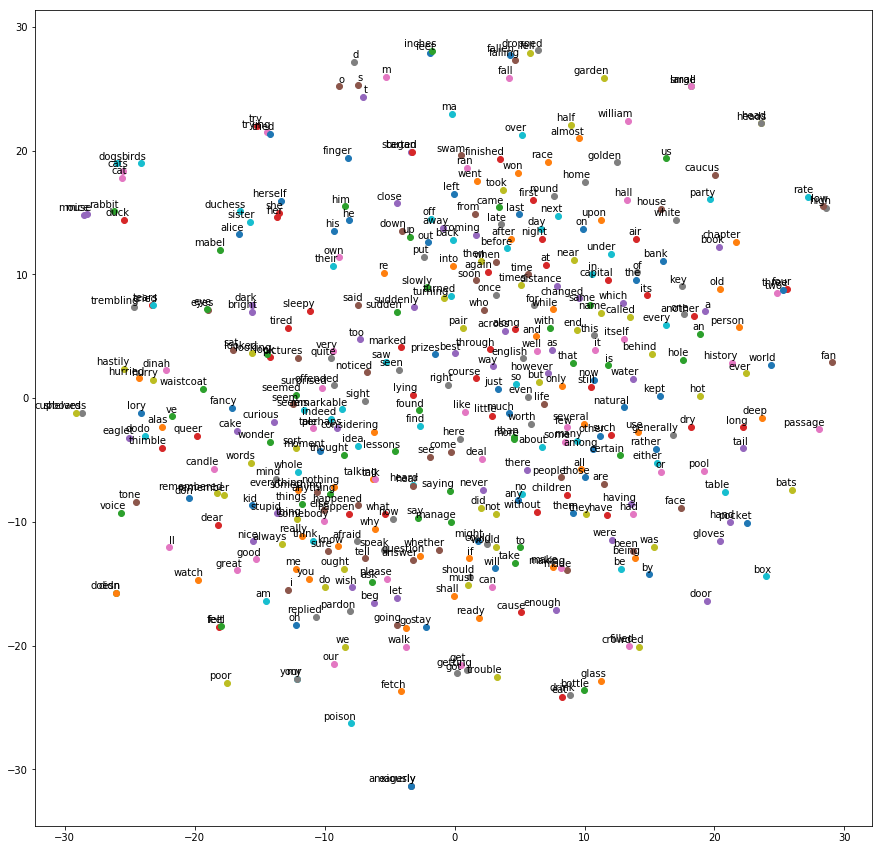

In [25]:
#these embeddings are now the embeddings of GloVe (rerun the code after creating the
#tsne for the glove word embeddings)

def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

def take(n, iterable):
    return list(islice(iterable, n))
inv_map_400 = take(400,tokenizer.word_index)

plot(two_d_embeddings, inv_map_400)

In [ ]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

l = linkage(w2v_skipgram.wv.syn0, method='complete', metric='seuclidean')

# calculate full dendrogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.ylabel('word')
plt.xlabel('distance')

dendrogram(
    l,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=16.,  # font size for the x axis labels
    orientation='left',
    leaf_label_func=lambda v: str(w2v_skipgram.wv.index2word[v])
)
plt.show()

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=20, random_state=0).fit(two_d_embeddings)
y_kmeans = kmeans.predict(two_d_embeddings)

fig, ax = plt.subplots(figsize=(20, 10))
ax.scatter(two_d_embeddings[:,0], two_d_embeddings[:, 1], c=y_kmeans, s=50, cmap='viridis')

for i, txt in enumerate(inv_map_400):
    plt.annotate(txt, two_d_embeddings[i])


Do some analogy tests and perform Gensim tasks

In [3]:
w2v_skipgram.wv.accuracy("./analogy_all.txt")

[{'correct': [], 'incorrect': [], 'section': 'capital-common-countries'},
 {'correct': [], 'incorrect': [], 'section': 'capital-world'},
 {'correct': [], 'incorrect': [], 'section': 'currency'},
 {'correct': [], 'incorrect': [], 'section': 'city-in-state'},
 {'correct': [],
  'incorrect': [('BROTHER', 'SISTER', 'HE', 'SHE'),
   ('BROTHER', 'SISTER', 'HIS', 'HER'),
   ('HE', 'SHE', 'HIS', 'HER'),
   ('HE', 'SHE', 'BROTHER', 'SISTER'),
   ('HIS', 'HER', 'BROTHER', 'SISTER'),
   ('HIS', 'HER', 'HE', 'SHE')],
  'section': 'family'},
 {'correct': [],
  'incorrect': [('SUDDEN', 'SUDDENLY', 'USUAL', 'USUALLY'),
   ('USUAL', 'USUALLY', 'SUDDEN', 'SUDDENLY')],
  'section': 'gram1-adjective-to-adverb'},
 {'correct': [], 'incorrect': [], 'section': 'gram2-opposite'},
 {'correct': [],
  'incorrect': [('BAD', 'WORSE', 'GOOD', 'BETTER'),
   ('BAD', 'WORSE', 'LARGE', 'LARGER'),
   ('BAD', 'WORSE', 'LONG', 'LONGER'),
   ('BAD', 'WORSE', 'OLD', 'OLDER'),
   ('BAD', 'WORSE', 'QUICK', 'QUICKER'),
   ('BA

In [ ]:
#random gensim stuff

print(w2v_skipgram.wv.most_similar(positive=['alice', 'rabbit'], negative=['hole']))
print(w2v_skipgram.wv.most_similar_cosmul(positive=['alice', 'rabbit'], negative=['hole']))
print(w2v_skipgram.wv.doesnt_match("alice rabbit dinah hole".split()))
print(w2v_skipgram.wv.similarity('dinah', 'rabbit'))

In [9]:
f = open('analogy_alice.txt' ,'r')

analogy = []
for row in f:
    row = row.replace("\n","")
    analogy.append(row.split(" "))

In [23]:
from scipy import linalg
from sklearn.metrics.pairwise import cosine_similarity

def cos_sim(a, b):
    sim = cosine_similarity([a],[b])
    return sim[0][0] 

def get_mean(positive_words,negative_words):
    sum = 0
    if len(positive_words+negative_words) > 0:
        for value in positive_words:
            sum = sum + value
        for value in negative_words:
            sum = sum - value
        return (sum/len(positive_words + negative_words))
    else:
        return None

def get_values_words(words,model):
    values = []
    for word in words:
        try:
            values.append(model[word])
        except KeyError:
            continue
    return values

def get_most_similar(model,topn,positive_words=[],negative_words=[]):
    most_similar = []
    values_words_positive = get_values_words(positive_words,model)
    values_words_negative = get_values_words(negative_words,model)
    mean_vector = get_mean(values_words_positive,values_words_negative)
    if isinstance(mean_vector,np.ndarray):
        for vector, word in zip(model.syn0,model.index2word):
            if word not in positive_words and word not in negative_words:
                sim = cos_sim(mean_vector,vector)
                most_similar.append((sim,word))
        final = sorted(most_similar, key=lambda tup: tup[0])[::-1]
        return final[0:topn]
    else:
        return("not in vocabulary")


In [7]:
#word2vec and glove are too big, you have to store them locally

path = "/Users/puckmulders/GoogleNews-vectors-negative300.bin"

word2vec = KeyedVectors.load_word2vec_format(path, binary=True)

In [23]:
# A king is to a queen as a man is to a ...
# A cat is to a kitten as a dog is to a ...
# Cats are to a cat as dogs are to a ...
# Find which words do not match from the following set of words:
# Man, cat, dog, rabbit
# Peanutbutter, tree, plant, flower
# King, queen, princess, civilian

print(word2vec.wv.n_similarity(['queen','king'],['woman','man']))
print(word2vec.wv.n_similarity(['cat','kitten'],['dog','puppy']))
print(word2vec.wv.n_similarity(['cat','cats'],['dog','dogs']))

print(word2vec.wv.similarity("unhappy","happy"))
print(word2vec.wv.similarity("cheerful","happy"))
print(word2vec.wv.similarity("cheerful","unhappy"))
print(word2vec.wv.similarity("synonym","equivalence"))
print(word2vec.wv.similarity("synonym","antonym"))

0.24791393122070618
0.8199700446967388
0.7703975883356613
0.6128037994197262
0.3837738197116679
0.20910789016696754
0.16996252561199232
0.5681054017923822


In [11]:
f = open('./pretrained_word2vec.txt' ,'w')
f.write(" ".join([str(V-1),str(300)]))
f.write("\n")

count = V - 1

for word in tokenizer.word_index.keys():
    try:
        str_vec = ' '.join(map(str, list(word2vec[word])))
        f.write('{} {}\n'.format(word, str_vec))
    except:
        count = count - 1

#I've created a file with only word embeddings of words in Alice in Wonderland
#open the pretrained word2vec file if you want to use only the embeddings of the book
#If you want to create your own text file, change the first number on the left to the count
print(count)
        
f.close()


1157


In [12]:
import gensim

path = "/Users/puckmulders/glove.6B/glove.6B.300d_converted.txt"

#these should be uncommented if you want to load GloVe yourself (to convert GloVe into 
#word2vec format)
#gensim.scripts.glove2word2vec.get_glove_info(path)
#gensim.scripts.glove2word2vec.glove2word2vec(path, "glove_converted.txt")

glove = KeyedVectors.load_word2vec_format(path, binary=False)

In [13]:
f = open('pretrained_glove.txt' ,'w')
f.write(" ".join([str(V-1),str(300)]))
f.write("\n")

count = V - 1

for word in tokenizer.word_index.keys():
    try:
        str_vec = ' '.join(map(str, list(glove[word])))
        f.write('{} {}\n'.format(word, str_vec))
    except:
        count = count - 1

#see comment of loading the pretrained word2vec file
print(count)
        
f.close()

1173


In [18]:
#load pretraind word2vec and glove limited to Alice in Wonderland
pretrained_glove = KeyedVectors.load_word2vec_format('pretrained_glove.txt')
pretrained_word2vec = KeyedVectors.load_word2vec_format('pretrained_word2vec.txt')

In [21]:
def get_correctness(model):
    all = 0
    correct = 0
    for row in analogy:
        all = all + 1
        print(row)
        options = get_most_similar(model=model,topn=4, positive_words=[row[1],row[2]],negative_words=[row[0]])
        print(options)
        if options != "not in vocabulary":
            best = options[0][1]
            if best == row[3]:
                correct = correct + 1

    print("correct: ", correct)
    print("total: ", all)

In [22]:
get_correctness(pretrained_glove)

['happy', 'unhappy', 'pleasant', 'unpleasant']
not in vocabulary
['sudden', 'suddenly', 'usual', 'usually']
[(0.4360684, 'tired'), (0.42970923, 'turned'), (0.4137993, 'even'), (0.4136945, 'getting')]
['bad', 'worse', 'good', 'better']
[(0.7447462, 'better'), (0.63282263, 'even'), (0.590295, 'but'), (0.5784646, 'think')]
['go', 'going', 'look', 'looking']
[(0.80130744, 'looking'), (0.73578066, 'really'), (0.70449394, 'think'), (0.6876728, 'things')]
['he', 'she', 'his', 'her']
[(0.9686025, 'her'), (0.6906713, 'my'), (0.63576734, 'own'), (0.6212543, 'daughter')]
['brother', 'sister', 'his', 'her']
[(0.8000885, 'her'), (0.6286537, 'she'), (0.6196902, 'own'), (0.5814765, 'my')]
['listen', 'listening', 'look', 'looking']
[(0.7328608, 'looking'), (0.61850315, 'looked'), (0.5724203, 'like'), (0.5353976, 'thinking')]
['saying', 'said', 'thinking', 'thought']
[(0.5991158, 'think'), (0.5510745, 'really'), (0.5466883, 'we'), (0.54252756, 'thought')]
['bird', 'birds', 'cat', 'cats']
[(0.68496174, 

In [24]:
#visualization of pretrained GloVe embeddings

num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(pretrained_glove.syn0[0:num_points, :])

## Question 3
TODO: Describe the ECG signal
The goal is to develop a model that will localize the QRC complex
TODO: Describe the data. Blocks of data with fixed width. QRC complex labelled with offset. 
In your solution: 
- Propose a model. 
- Define the input shape for the model
- Define the number of layers
- Define number of neurons for each layer
- Define the activation functions. 
- Define the output shape. 
- Define the loss function. 

Justify your decisions
- No implementation is needed. 